# Twitter Disaster Detection Model 

In [1]:

! pip3 install -r requirements.txt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random
import torch
from torch import nn, optim
import math
from IPython import display
import requests
import torch.nn.functional as F

### Pre-processing

Preprocessing done in a seperate file and saved in preprocessed_(test/tain).csv, so the long process does not need to occur each run

### Device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Import CSV's

In [3]:
train_df = pd.read_csv('preprocessed_train.csv', sep=',', encoding='latin-1')
test_df = pd.read_csv("test.csv")

In [4]:
data = train_df[['keyword', 'location', 'sarcastic', 'not_sarcastic', 'negative', 'neutral', 'positive']]
target = train_df['target']
#print(X_data["neutral"])
train_data, val_data, train_target, val_target = train_test_split(data, target, test_size = 0.2)
print(train_target)
# split the dataset into training and validation sets
#train_data, val_data = 
#print(train_data[:]["sarcastic"])
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)


5248    1
1090    0
3039    1
34      0
3451    0
       ..
4406    0
4004    1
749     0
1894    0
6370    1
Name: target, Length: 6088, dtype: int64


### Convert categorical features in a DataFrame to one-hot encoding

In [5]:
def convert_features_to_one_hot(df, feature_name_list):
  for feature_name in feature_name_list:
    df = pd.get_dummies(df, columns=[feature_name])
  
  return df
#Define the training set/test set from the imported data... x_train, x_val, etc... needs to be predefined

data_to_convert = ['train_data', 'val_data']

feature_list = ['location', 'keyword']
for i,ix in enumerate(data_to_convert):
  exec(f'{data_to_convert[i]} = convert_features_to_one_hot({ix}, {feature_list})')


In [6]:
print(len(train_data.keys()))
input_layers = len(train_data.keys())

3011


### Model draft 

In [7]:
class netmodel(nn.Module):
  def __init__(self, input_layer=1, num_hidden=1, node_per_hidden=32, droppout=0., LSTM_layers=0, outputs=2):
    super(netmodel, self).__init__()
    self.input_layer = input_layer
    self.num_hidden = num_hidden 
    self.node_per_hidden = node_per_hidden
    self.droppout = droppout 
    self.SLTM_layers = LSTM_layers 
    self.outputs = outputs 
    self.inputfc = nn.Linear(input_layer, node_per_hidden) 
    self.hiddenfc = [] 
    for i in range(num_hidden-1):
      self.hiddenfc.append(nn.Linear(node_per_hidden, node_per_hidden))
    self.lastfc = nn.Linear(node_per_hidden, outputs)

  def forward(self, x, debug=False):
    drop = nn.Dropout(p=self.droppout)
    #x = x.view(1,1)
    x = self.inputfc(x)
    x = F.relu(x)
    x = drop(x)
    for i in range(self.num_hidden-1):
      x = self.hiddenfc[i](x)
      x = F.relu(x)
      x = drop(x)
    
    x = self.lastfc(x)
    x = F.softmax(x, dim=1)
    return x 



In [37]:
Model = netmodel(input_layer=input_layers, num_hidden=50, node_per_hidden=64, droppout=0.3).to(device)

#Model.forward(torch.tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

### Build loaders + set variables

In [38]:


batch_size = 32
print(len(train_data))
print(len(train_target))
#tensor_train = torch.utils.data.TensorDataset(train_data, train_target)
tensor_train = torch.tensor(train_data.values.astype(float), dtype=torch.float32).to(device)
tensor_train_labels = torch.tensor(train_target.values.astype(float), dtype=torch.long).to(device)
tensor_train_set = torch.utils.data.TensorDataset(tensor_train, tensor_train_labels)

# Convert validation data to PyTorch tensors and move to device
#tensor_val = torch.utils.data.TensorDataset(val_data, val_target)
tensor_val = torch.tensor(val_data.values.astype(float), dtype=torch.float32).to(device)
tensor_val_labels = torch.tensor(val_target.values.astype(float), dtype=torch.long).to(device)
tensor_val_set = torch.utils.data.TensorDataset(tensor_val, tensor_val_labels)

train_loader = torch.utils.data.DataLoader(tensor_train_set, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(tensor_val_set, batch_size=batch_size, shuffle=True)

lr = 1e-3
lambda_l2 = 1e-3
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(Model.parameters(), lr=lr, weight_decay=lambda_l2)



6088
6088


In [40]:
def train_model(epochs, model):
    losses = []
    model.train()
    for epoch in range(epochs):
      for batch_id, (data, label) in enumerate(train_loader):
        #print(batch_idx)


        pred = Model.forward(data)
        #print(type(pred[0][0].item()))

        optimizer.zero_grad()
        loss = loss_func(pred, label)
        
        #print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        if batch_id % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_id * len(data), len(train_loader.dataset),
            100. * batch_id / len(train_loader), loss.item()))
          
    return losses 

In [41]:
losses = train_model(10, Model)


Train Epoch: 0 [0/6088 (0%)]	Loss: 0.694826
Train Epoch: 0 [3200/6088 (52%)]	Loss: 0.682447
Train Epoch: 1 [0/6088 (0%)]	Loss: 0.722706
Train Epoch: 1 [3200/6088 (52%)]	Loss: 0.692383
Train Epoch: 2 [0/6088 (0%)]	Loss: 0.678328
Train Epoch: 2 [3200/6088 (52%)]	Loss: 0.695278
Train Epoch: 3 [0/6088 (0%)]	Loss: 0.679066
Train Epoch: 3 [3200/6088 (52%)]	Loss: 0.686897
Train Epoch: 4 [0/6088 (0%)]	Loss: 0.659042
Train Epoch: 4 [3200/6088 (52%)]	Loss: 0.642273
Train Epoch: 5 [0/6088 (0%)]	Loss: 0.680987
Train Epoch: 5 [3200/6088 (52%)]	Loss: 0.685553
Train Epoch: 6 [0/6088 (0%)]	Loss: 0.676755
Train Epoch: 6 [3200/6088 (52%)]	Loss: 0.683178
Train Epoch: 7 [0/6088 (0%)]	Loss: 0.670792
Train Epoch: 7 [3200/6088 (52%)]	Loss: 0.644660
Train Epoch: 8 [0/6088 (0%)]	Loss: 0.638346
Train Epoch: 8 [3200/6088 (52%)]	Loss: 0.659537
Train Epoch: 9 [0/6088 (0%)]	Loss: 0.711194
Train Epoch: 9 [3200/6088 (52%)]	Loss: 0.715441


0.6948258


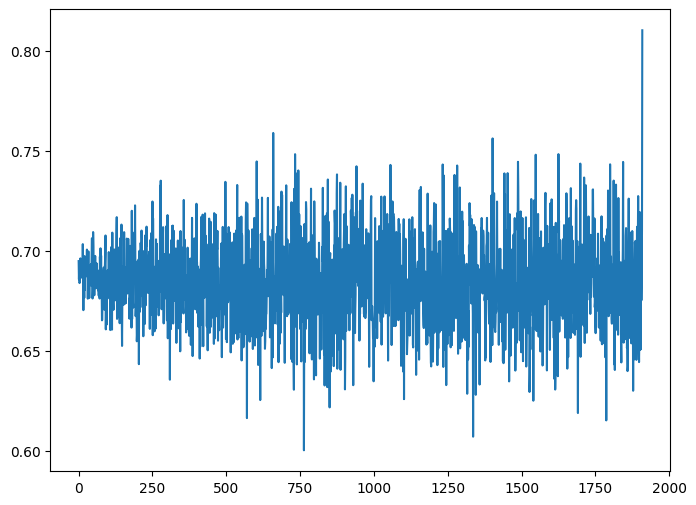

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
print(losses[0])
ax.plot(range(0, len(losses)), losses)

In [14]:
def test_model(model, loader):
    model.eval()
    losses = [] 
    with torch.no_grad():
      for batch_id, (data, label) in enumerate(loader):
        #print(batch_idx)


        pred = Model.forward(data)
        #print(type(pred[0][0].item()))

        optimizer.zero_grad()
        loss = loss_func(pred, label)
        losses.append(loss)
        #print(loss)
        loss.backward()
        optimizer.step()
        if batch_id % 100 == 0:
          print('Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            batch_id * len(data), len(loader.dataset),
            100. * batch_id / len(loader), loss.item()))
          
    return losses

In [15]:
test_model(Model, val_loader)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1047 and 3011x32)